In [ ]:
"""Authors:Alexander Henkes & Pavan Ramesh Hallur, CNN for homogenization"""
import tensorflow as tf
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()
tf.config.optimizer.set_jit(True)

In [ ]:
SAMPLES = int(1e6)
VAL_SPLIT = 0.5
BATCH = int(2 ** 14)
EPOCHS = int(1e4)
SIZE = 32
LR = 1e-3

In [ ]:
def generate_microstructure(samples=100, size=10):
    """Generate 1D heterogeneous microstructures."""
    microstructures = tf.random.uniform(shape=[samples, size],
                                        minval=0,
                                        maxval=2,
                                        dtype="int32")

    microstructures = tf.cast(microstructures, tf.float32)
    return microstructures

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[61.414562],
       [84.82027 ],
       [55.324577],
       [26.729357],
       [29.297209]], dtype=float32)>

In [ ]:
def temp(x):
    y = x ** 2 + 3
    return y

In [ ]:
x

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[98.24475  ],
       [ 4.1693926],
       [20.401001 ],
       [86.175606 ],
       [80.707695 ]], dtype=float32)>

In [ ]:
y = temp(x)
y

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[9655.032   ],
       [  20.383835],
       [ 419.20084 ],
       [7429.235   ],
       [6516.732   ]], dtype=float32)>

In [ ]:
def dataset(samples):
    x = tf.random.uniform(shape=[samples,1],
                    minval=0.0,
                    maxval=100.0,
                    dtype='float32')
    return x, temp(x)

In [ ]:
training_set = dataset(10)
training_set[1]

<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[ 380.90924 ],
       [5307.827   ],
       [5642.3325  ],
       [  10.532978],
       [ 563.27423 ],
       [9629.372   ],
       [6834.036   ],
       [1259.9633  ],
       [ 124.45365 ],
       [ 390.85065 ]], dtype=float32)>

In [ ]:
test_set = dataset(5)
test_set


(<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[31.00332 ],
        [72.44651 ],
        [19.796955],
        [62.905396],
        [72.756386]], dtype=float32)>,
 <tf.Tensor: shape=(5, 1), dtype=float32, numpy=
 array([[ 964.2059 ],
        [5251.497  ],
        [ 394.91943],
        [3960.0886 ],
        [5296.4917 ]], dtype=float32)>)

In [ ]:
def youngs_modulus(microstructure):
  x = microstructure.numpy()
  x[x>0.5] = 5000
  x[x<0.5] = 1000
  youngs_modulus = tf.convert_to_tensor(x, dtype="float32")
  return youngs_modulus


In [ ]:
def effective_youngs_modulus(youngs_modulus, microstructure):
  vf = tf.reduce_mean(microstructure, axis=1)
  E_f = tf.reduce_max(youngs_modulus)
  E_m = tf.reduce_min(youngs_modulus)
  E_c = 1.0 / ((vf / E_f) + ((1.0 - vf) / E_m))
  E_c = tf.expand_dims(E_c, axis=1)
  return E_c

In [ ]:
microstructure = generate_microstructure(samples=SAMPLES, size=SIZE)
microstructure.shape

TensorShape([1000000, 32])

In [ ]:
youngs = youngs_modulus(microstructure=microstructure)
youngs.shape

TensorShape([1000000, 32])

In [ ]:
effective_youngs = effective_youngs_modulus(youngs_modulus=youngs, 
                                            microstructure=microstructure)
effective_youngs.shape

TensorShape([1000000, 1])

(array([2.52240e+04, 2.72994e+05, 5.13670e+05, 1.33194e+05, 5.15310e+04,
        2.35400e+03, 9.77000e+02, 5.10000e+01, 4.00000e+00, 1.00000e+00]),
 array([1081.081 , 1336.6094, 1592.1376, 1847.6659, 2103.194 , 2358.7224,
        2614.2507, 2869.779 , 3125.3071, 3380.8354, 3636.3638],
       dtype=float32),
 <a list of 10 Patch objects>)

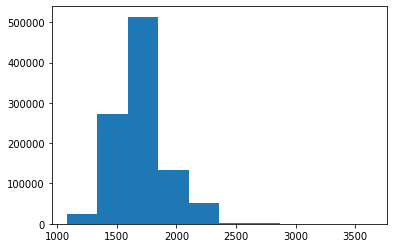

In [ ]:
plt.hist(x=effective_youngs[:, 0])

In [ ]:
INITIALIZER = 'orthogonal'
model = tf.keras.Sequential()

# for hidden in range(1):
model.add(tf.keras.layers.InputLayer(input_shape=[SIZE, 1]))

for hidden in range(4):
    model.add(tf.keras.layers.Conv1D(filters=8 * (hidden + 1), 
                                    kernel_size=3, 
                                    strides=1, 
                                    padding='same',
                                    kernel_initializer=INITIALIZER,
                                    activation='relu'))
    
    model.add(tf.keras.layers.Conv1D(filters=8 * (hidden + 1), 
                                    kernel_size=3, 
                                    strides=1, 
                                    padding='same',
                                    kernel_initializer=INITIALIZER,
                                    activation='relu'))

    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.GlobalMaxPool1D())

model.add(tf.keras.layers.Reshape([-1]))

model.add(tf.keras.layers.Dense(units=1, activation='linear'))


model.compile(optimizer=tf.keras.optimizers.Nadam(LR), loss='logcosh')
model.summary(100)

Model: "sequential"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 conv1d (Conv1D)                             (None, 32, 8)                           32             
                                                                                                    
 conv1d_1 (Conv1D)                           (None, 32, 8)                           200            
                                                                                                    
 max_pooling1d (MaxPooling1D)                (None, 16, 8)                           0              
                                                                                                    
 conv1d_2 (Conv1D)                           (None, 16, 16)                          400            
                                                                       

In [ ]:
extended_microstructure = tf.expand_dims(microstructure, axis=2)
extended_microstructure.shape

TensorShape([1000000, 32, 1])

In [ ]:
scaler = tf.constant(0.5, tf.float32)
extended_microstructure = (extended_microstructure - scaler) / scaler

In [ ]:
print(tf.reduce_max(effective_youngs))
print(tf.reduce_min(effective_youngs))

tf.Tensor(3636.3638, shape=(), dtype=float32)
tf.Tensor(1081.081, shape=(), dtype=float32)


In [ ]:
scaler = (tf.reduce_max(effective_youngs) + tf.reduce_min(effective_youngs)) / 2.0
effective_youngs = (effective_youngs - scaler) / scaler

In [ ]:
print(tf.reduce_max(effective_youngs))
print(tf.reduce_min(effective_youngs))

tf.Tensor(0.5416667, shape=(), dtype=float32)
tf.Tensor(-0.5416667, shape=(), dtype=float32)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=20, verbose=1,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
history = model.fit(x=extended_microstructure, 
                    y=effective_youngs, 
                    batch_size=BATCH, 
                    epochs=EPOCHS, 
                    validation_split=VAL_SPLIT,
                    verbose=1,
                    callbacks=[callback])

Epoch 1/10000
31/31 [==============================] - 20s 138ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 2/10000
31/31 [==============================] - 5s 168ms/step - loss: 0.0011 - val_loss: 7.0087e-04
Epoch 3/10000
31/31 [==============================] - 2s 51ms/step - loss: 8.1856e-04 - val_loss: 7.2275e-04
Epoch 4/10000
31/31 [==============================] - 1s 47ms/step - loss: 6.1136e-04 - val_loss: 6.1189e-04
Epoch 5/10000
31/31 [==============================] - 2s 51ms/step - loss: 5.2410e-04 - val_loss: 4.7005e-04
Epoch 6/10000
31/31 [==============================] - 1s 48ms/step - loss: 4.6994e-04 - val_loss: 4.2190e-04
Epoch 7/10000
31/31 [==============================] - 2s 51ms/step - loss: 4.0708e-04 - val_loss: 3.8081e-04
Epoch 8/10000
31/31 [==============================] - 1s 48ms/step - loss: 3.9204e-04 - val_loss: 3.6698e-04
Epoch 9/10000
31/31 [==============================] - 2s 51ms/step - loss: 3.4207e-04 - val_loss: 3.3371e-04
Epoch 10/10000
31/3

In [ ]:
model.evaluate(extended_microstructure, 
               effective_youngs, 
               batch_size=BATCH)

62/62 [==============================] - 1s 8ms/step - loss: 9.5361e-06


9.536098332318943e-06

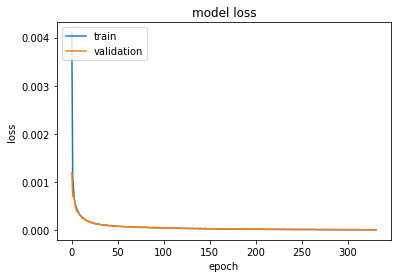

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

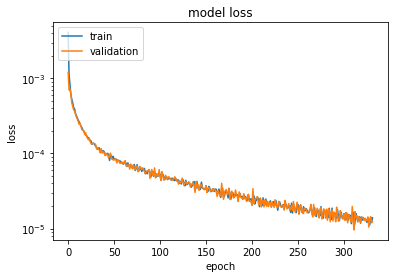

In [ ]:
# summarize history for loss
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predicted_eff_youngs = model.predict(extended_microstructure, batch_size=BATCH)

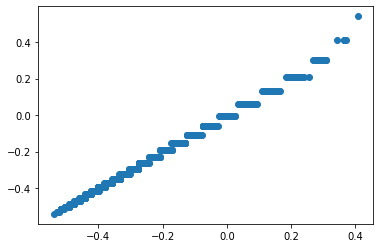

In [ ]:
plt.scatter(x=predicted_eff_youngs, y=effective_youngs)
plt.show()

In [ ]:
predicted_eff_youngs[:10, 0] * scaler + scaler

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1742.365 , 1909.9658, 1671.1089, 1816.3948, 1601.3391, 1487.1055,
       2240.9666, 1678.0732, 1548.0642, 1744.3226], dtype=float32)>